In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from cd_diagram import draw_cd_diagram

from IPython.display import display

%matplotlib inline

#sns.set()
#sns.set_theme(style="whitegrid", palette="pastel")

# Helper functions

In [2]:
def get_best_row(group):
    idx_min_rmsse = group.rmsse.idxmin()
    return group.loc[idx_min_rmsse].drop('id_piezo')

In [3]:
def plot_best_models(result_df):
    best_models = result_df.reset_index(drop=True).groupby('id_piezo').apply(get_best_row)
    models_and_stations = best_models.join(sources)
    
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    ax.set_extent([-5, 10, 42, 52])

    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    ax.set_ylabel('Latitude')
    ax.set_xlabel('Longitude')
    sns.scatterplot(data=models_and_stations, x='x', y='y', hue='model', ax=ax) 

    ax.set_title('France');

    plt.tight_layout()
    plt.show()
#plt.savefig('Images/plot_clusters.png')

In [4]:
def plot_stats(result_df, figsize=(8, 5), fname=None):
    plt.figure(figsize=figsize)
    ax = sns.boxplot(data=result_df, y='rmsse', x='model', boxprops={'facecolor':'none', 'edgecolor':'black'})
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_yscale('log')
    
    plt.tight_layout()
    
    if fname is not None:
        plt.savefig(fname)
        
    plt.show()
    
    agg_metrics = result_df.groupby('model')[['rmsse']].agg(['mean', 'std']).T
    display(agg_metrics)

In [5]:
def plot_forecast(forecast_df): 

    nrows = 6
    ncols = 3

    plt.figure(figsize=(20, 20))

    for i, (index, row) in enumerate(forecast_df[['BSS_ID', 'NOM_COMMUNE']].iterrows()):
        df = forecast_def[forecast_def.index==index]
        df = df.set_index('DATE')

        ax = plt.subplot(nrows, ncols, i+1)
        df.plot(ax=ax, title=f'Piézomètre {row.BSS_ID} ({row.NOM_COMMUNE})', xlabel='')
        
        if i == 17:
            break

    plt.tight_layout()
    #plt.savefig('Images/forecasts.png')
    plt.show()

In [21]:
def show_performance(result_df, show_map=False, barplot_fname=None, cd_fname=None):
    res = result_df.copy()
    if res.shape[0] > 0:
        plot_stats(res, fname=barplot_fname)

        if show_map:
            plot_best_models(res)
            
        try :
            res.rmsse = -res.rmsse
            draw_cd_diagram(res.rename(columns={'id_piezo': 'dataset_name', 'model': 'classifier_name', 'rmsse': 'accuracy'}), fname=cd_fname)
            plt.show()
        except Exception as e:
            print(e)
            
    else:
        print('No result for these covariates\n\n\n')

In [7]:
def rename_model(row):
    name = row.model
    if row.use_exo_rain:
        name += '+rain'
    if row.use_exo_eto:
        name += '+eto'
    row.model = name
    return row

In [8]:
result_folder = './'

# Load stations

In [9]:
sources = pd.read_csv('../data_collection/stations.csv', delimiter=',', index_col=0)
sources.head()

,x,y,geometry,dpt,prof,alt,masse_eau,codes_bdlisa,CodeEH,InclusEH,EtatEH,NatureEH,MilieuEH,ThemeEH,OrigineEH
bss,,,,,,,,,,,,,,,
06216X0228/P30-10,3.401730,46.272865,"{'type': 'Point', 'crs': {'type': 'name', 'pro...",03,8.0,237.20,"[""Alluvions de l'Allier aval""]",932AR01,932AR01,932AR,2,5.0,1,1.0,1.0
05373X0546/5410,-0.879629,47.059019,"{'type': 'Point', 'crs': {'type': 'name', 'pro...",49,23.4,106.00,['Bassin versant de la Sèvre Nantaise'],181AE01,181AE01,181AE,2,6.0,2,3.0,1.0
01193X0168/FEA10,-0.488171,49.295510,"{'type': 'Point', 'crs': {'type': 'name', 'pro...",14,30.0,13.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10396X0083/SA10,3.022001,43.209046,"{'type': 'Point', 'crs': {'type': 'name', 'pro...",11,19.3,5.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
07372X0048/F10,1.538653,45.529764,"{'type': 'Point', 'crs': {'type': 'name', 'pro...",19,138.0,396.00,NaN,372AG03,372AG03,372AG,2,6.0,2,3.0,1.0


In [10]:
common_piezo = pd.read_csv('piezos_communs.csv', ).squeeze()
print(common_piezo.shape)
common_piezo.head()

(1026,)


0       06143X0011/S
1       09273X0205/F
2       02408X0016/F
3     00216X0073/PZ3
4    02551X0022/FAEP
Name: 0, dtype: object

In [11]:
missing_source = set(common_piezo).difference(sources.index)
print(missing_source)

{'01258X0020/S1', '06505X0080/FORC', '07223C0113/S'}


# Legacy results

In [13]:
tmp = pd.read_csv(result_folder + 'local_all_r100_evo.csv', delimiter='\t')
tmp.head()

,id_piezo,id_method_ML,type,r,use_exo_rain,use_exo_eto,use_exo_bdlisa,approx_exo,rmsse,mse
0,00065X0148/P,lm,Local,100,False,True,False,False,0.964284,0.022997
1,00065X0148/P,svr,Local,100,False,True,False,False,0.755309,0.014109
2,00065X0148/P,rf,Local,100,False,True,False,False,0.964541,0.023009
3,00068X0010/F295,lm,Local,100,False,True,False,False,1.431731,0.055483
4,00068X0010/F295,svr,Local,100,False,True,False,False,0.637952,0.011016


In [14]:
files = [result_folder + 'oldTG_local_part1.csv', 
          result_folder + 'oldTG_local_part2.csv',
          result_folder + 'oldTG_local_part3.csv',
          result_folder + 'oldTG_local_part4.csv',
          result_folder + 'oldTG_local_cmpl.csv',
          result_folder + 'oldTG_local_xgb.csv',
          result_folder + 'local_all_r100_evo.csv',
          result_folder + 'local_xgb_r100_evo.csv'
        ]
legacy_result = pd.concat([pd.read_csv(file, delimiter='\t') for file in files])
legacy_result['rmse'] = np.sqrt(legacy_result.mse)
legacy_result = legacy_result.rename(columns={'id_method_ML': 'model'})
legacy_result = legacy_result[~legacy_result.approx_exo]
legacy_result = legacy_result[legacy_result.id_piezo.isin(common_piezo)]
legacy_result.model = legacy_result.model.apply(lambda m: m.upper())
legacy_result = legacy_result.apply(rename_model, axis=1)

legacy_result.head()

,id_piezo,model,type,r,use_exo_rain,use_exo_eto,use_exo_bdlisa,approx_exo,rmsse,mse,rmse
0,00065X0148/P,LM,Local,100.0,False,False,False,False,0.678561,0.010110,0.100549
2,00065X0148/P,LM+rain,Local,100.0,True,False,False,False,3.557765,0.277926,0.527187
4,00065X0148/P,LM+rain+eto,Local,100.0,True,True,False,False,1.676050,0.061680,0.248356
6,00065X0148/P,SVR,Local,100.0,False,False,False,False,2.311324,0.117299,0.342490
8,00065X0148/P,SVR+rain,Local,100.0,True,False,False,False,1.311381,0.037760,0.194319


In [15]:
legacy_result = legacy_result[~legacy_result.model.str.startswith('ARIMA')]

In [16]:
legacy_result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16416 entries, 0 to 1364
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_piezo        16416 non-null  object 
 1   model           16416 non-null  object 
 2   type            16416 non-null  object 
 3   r               16416 non-null  float64
 4   use_exo_rain    16416 non-null  bool   
 5   use_exo_eto     16416 non-null  bool   
 6   use_exo_bdlisa  16416 non-null  bool   
 7   approx_exo      16416 non-null  bool   
 8   rmsse           16416 non-null  float64
 9   mse             16416 non-null  float64
 10  rmse            16416 non-null  float64
dtypes: bool(4), float64(4), object(3)
memory usage: 1.1+ MB


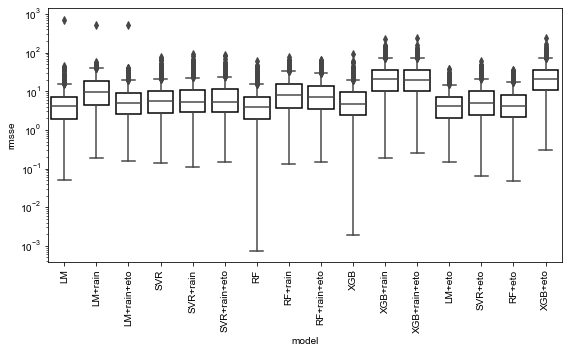

model              LM    LM+eto    LM+rain  LM+rain+eto        RF    RF+eto  \
rmsse mean   6.347190  5.582148  13.446660     7.670732  5.985972  6.175408   
      std   22.936639  5.159568  19.381115    17.319259  6.552988  5.898804   

model         RF+rain  RF+rain+eto       SVR   SVR+eto  SVR+rain  \
rmsse mean  11.301827    10.336519  8.142766  7.332672  8.801061   
      std   10.823635     9.852539  8.846874  7.604155  9.899599   

model       SVR+rain+eto       XGB    XGB+eto   XGB+rain  XGB+rain+eto  
rmsse mean      8.741238  7.289935  26.445743  26.426847     25.716882  
      std       9.611169  7.936318  22.759168  23.163022     22.603823

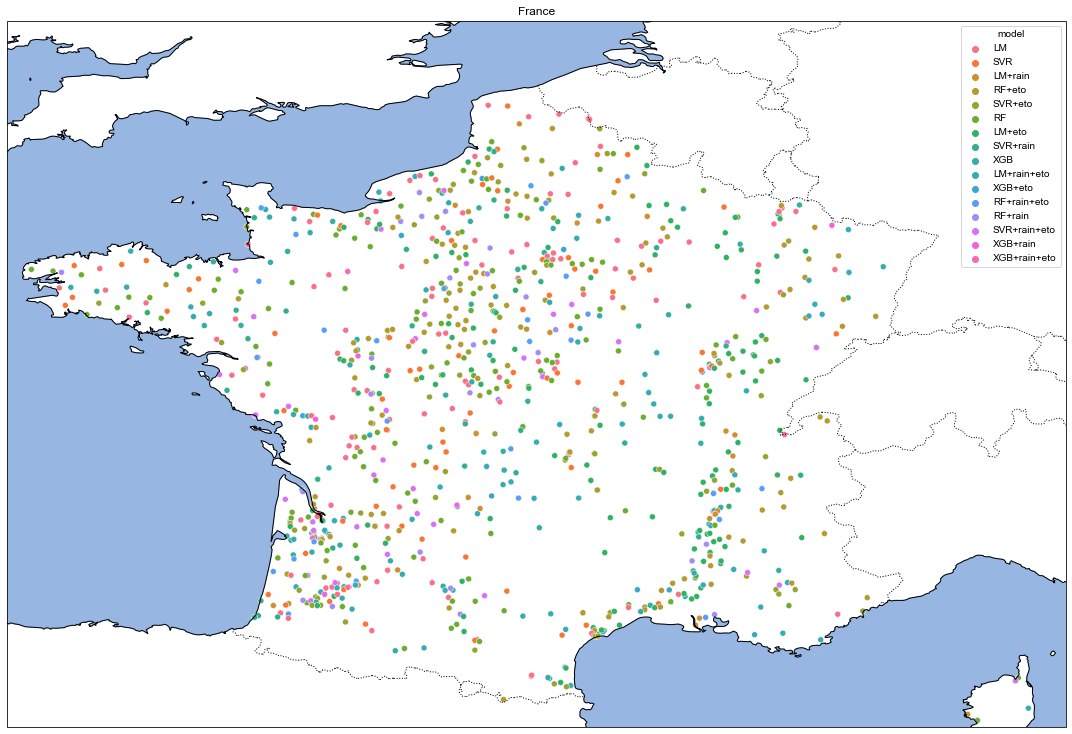

{0: 'XGB+eto', 1: 'XGB+rain', 2: 'XGB+rain+eto', 3: 'LM+rain', 4: 'RF+rain', 5: 'RF+rain+eto', 6: 'SVR+rain', 7: 'SVR', 8: 'SVR+rain+eto', 9: 'SVR+eto', 10: 'XGB', 11: 'LM+rain+eto', 12: 'RF+eto', 13: 'RF', 14: 'LM', 15: 'LM+eto'}
[0, 1]
[7, 8, 6]
[7, 9, 11]
[10, 9, 11]
[12, 13, 14]
[13, 15, 14]


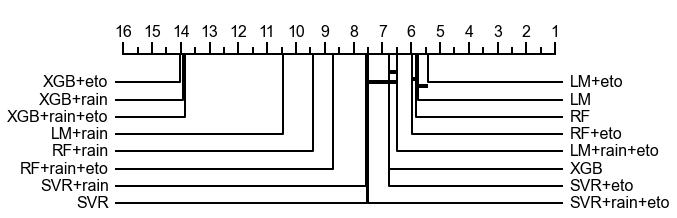

In [22]:
show_performance(legacy_result, show_map=True, barplot_fname='Images/boxplot-legacy.eps', cd_fname='Images/cd-legacy.eps')

In [23]:
best_legacy_models = {'LM+eto', 'LM+rain+eto', 'XGB+eto', 'LM+rain'}

# Deepar results

In [24]:
deepar_local_result = pd.read_csv(result_folder + 'local_DeepAR.csv', index_col=0)
deepar_local_result = deepar_local_result.rename(columns={'item_id': 'id_piezo', 'use_exo_evo': 'use_exo_eto'})
deepar_local_result = deepar_local_result[deepar_local_result.id_piezo.isin(common_piezo)]

if 'use_exo_bdlisa' not in deepar_local_result.columns:
    deepar_local_result['use_exo_bdlisa'] = False
    
deepar_local_result['type'] = 'Local'
deepar_local_result['model'] = 'DeepAR-L'

deepar_global_result = pd.read_csv(result_folder + 'global_DeepAR.csv', index_col=0)
deepar_global_result = deepar_global_result.rename(columns={'item_id': 'id_piezo', 'use_exo_evo': 'use_exo_eto'})
deepar_global_result = deepar_global_result[deepar_global_result.id_piezo.isin(common_piezo)]
deepar_global_result.rmsse = deepar_global_result.rmsse.astype(float)
deepar_global_result = deepar_global_result.replace(to_replace='False', value=False)
deepar_global_result.use_exo_rain = deepar_global_result.use_exo_rain.astype(bool)
deepar_global_result.use_exo_eto = deepar_global_result.use_exo_eto.astype(bool)

if 'use_exo_bdlisa' not in deepar_global_result.columns:
    deepar_global_result['use_exo_bdlisa'] = False
    
deepar_global_result['type'] = 'Global'
deepar_global_result['model'] = 'DeepAR-G'

deepar_result = pd.concat([deepar_local_result, deepar_global_result])
deepar_result = deepar_result.apply(rename_model, axis=1)
deepar_result.head()

,Unnamed: 0.6,Unnamed: 0.5,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,id_piezo,MSE,abs_error,...,model,learningtime,use_exo_rain,use_exo_eto,rmse,rmsse,use_exo_bdlisa,type,use_exo_lisa,TN
4,4.0,4.0,4.0,4.0,4.0,4.0,0.0,00065X0148/P,0.308370,44.914196,...,DeepAR-L+rain+eto,278.069091,True,True,0.555310,3.577621,False,Local,NaN,NaN
5,5.0,5.0,5.0,5.0,5.0,5.0,0.0,00065X0148/P,0.214006,36.915985,...,DeepAR-L+rain,279.152479,True,False,0.462608,2.980377,False,Local,NaN,NaN
6,6.0,6.0,6.0,6.0,6.0,6.0,0.0,00065X0148/P,0.283600,44.821762,...,DeepAR-L+eto,293.467366,False,True,0.532541,3.430925,False,Local,NaN,NaN
7,7.0,7.0,7.0,7.0,7.0,7.0,0.0,00065X0148/P,0.520745,61.014584,...,DeepAR-L,300.382821,False,False,0.721627,4.649122,False,Local,NaN,NaN
8,8.0,8.0,8.0,8.0,8.0,8.0,0.0,00068X0010/F295,1.712516,106.250275,...,DeepAR-L+rain+eto,278.234030,True,True,1.308631,8.063753,False,Local,NaN,NaN


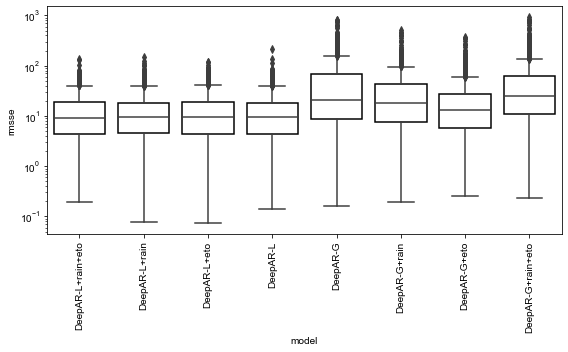

model        DeepAR-G  DeepAR-G+eto  DeepAR-G+rain  DeepAR-G+rain+eto  \
rmsse mean  57.680631     24.334162      35.574532          56.142484   
      std   96.156533     37.152423      52.643441          94.505637   

model        DeepAR-L  DeepAR-L+eto  DeepAR-L+rain  DeepAR-L+rain+eto  
rmsse mean  14.723336     14.898500      14.705740          14.382224  
      std   16.689749     15.776049      16.313824          15.275161

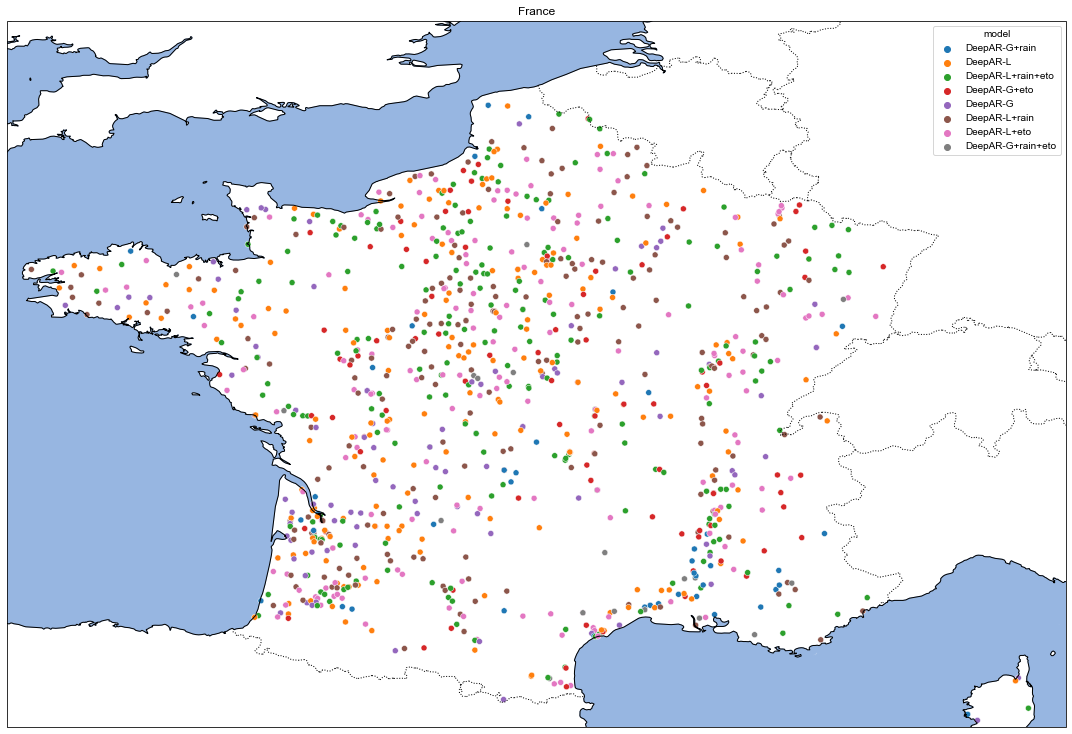

{0: 'DeepAR-G+rain+eto', 1: 'DeepAR-G', 2: 'DeepAR-G+rain', 3: 'DeepAR-G+eto', 4: 'DeepAR-L+eto', 5: 'DeepAR-L+rain+eto', 6: 'DeepAR-L+rain', 7: 'DeepAR-L'}
[0, 1]
[4, 5, 6, 7]


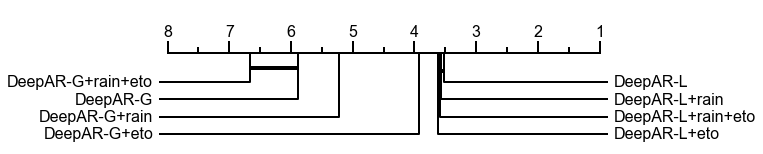

In [25]:
show_performance(deepar_result, show_map=True, barplot_fname='Images/boxplot-deepar.eps', cd_fname='Images/cd-deepar.eps')

In [26]:
# we chose the best local version of Deep AR and its best global version 
best_deepar_models = {'DeepAR-L', 'DeepAR-G+eto', 'DeepAR-G+rain+eto', 'DeepAR-G+rain'}

# Prophet, NeuralProphet and Conv results

In [27]:
neuralprophet_global = pd.read_csv(result_folder+'neuralprophet_global.csv', delimiter=',').rename(columns={'Unnamed: 0': 'bss_code'})
neuralprophet_global.model = 'NeuralProphet-G'
neuralprophet_global['type'] = 'Global'

files = [
          result_folder + 'local_prophet.csv', 
          result_folder + 'local_neuralprophet.csv',
          #result_folder + 'local_Conv.csv',
        ]

deeplearning_result = pd.concat([pd.read_csv(file, delimiter=',') for file in files])
deeplearning_result.model = deeplearning_result.model.replace('neuralprophet', value='NeuralProphet-L')
deeplearning_result['type'] = 'Local'

deeplearning_result = pd.concat([deeplearning_result, neuralprophet_global], axis=0)

deeplearning_result = deeplearning_result.rename(columns={'bss_code': 'id_piezo', 'rmse_test': 'rmse', 'rmsse_test': 'rmsse', 'use_exo_evo': 'use_exo_eto'})
deeplearning_result = deeplearning_result[deeplearning_result.id_piezo.isin(common_piezo)]
deeplearning_result.model = deeplearning_result.model.replace({'prophet': 'Prophet'})


if 'use_exo_bdlisa' not in deeplearning_result.columns:
    deeplearning_result['use_exo_bdlisa'] = False

deeplearning_result = deeplearning_result.apply(rename_model, axis=1)
deeplearning_result.head()

,id_piezo,model,rmse_train,rmse,rmsse_train,rmsse,learningtime,use_exo_rain,use_exo_eto,h1,...,h86,h87,h88,h89,h90,h91,h92,h93,type,use_exo_bdlisa
4,00065X0148/P,Prophet,0.308735,0.282583,2.007717,1.837651,0.702274,False,False,1.082109,...,0.763810,0.781719,0.764617,0.750875,0.745400,0.757558,0.737699,0.750746,Local,False
5,00065X0148/P,Prophet+rain,0.301175,0.258691,1.958556,1.682278,0.643840,True,False,1.131278,...,0.816696,0.836948,0.825391,0.771921,0.652766,0.714907,0.350567,0.811579,Local,False
6,00065X0148/P,Prophet+eto,0.299752,0.248236,1.949303,1.614289,0.794361,False,True,1.091117,...,0.802474,0.857490,0.826903,0.773760,0.613735,0.806678,0.731351,0.748738,Local,False
7,00065X0148/P,Prophet+rain+eto,0.294434,0.243034,1.914715,1.580461,0.616374,True,True,1.127481,...,0.838248,0.889592,0.865493,0.786197,0.557603,0.763794,0.418859,0.796979,Local,False
8,00068X0010/F295,Prophet,0.271972,1.261550,1.678213,7.784430,2.905123,False,False,24.423687,...,21.993809,21.947244,21.886258,21.856302,21.809436,21.748219,21.685697,21.647721,Local,False


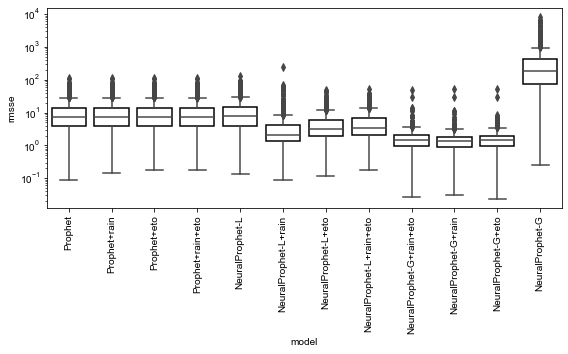

model       NeuralProphet-G  NeuralProphet-G+eto  NeuralProphet-G+rain  \
rmsse mean       390.138255             1.656578              1.532750   
      std        716.540649             2.037317              2.093355   

model       NeuralProphet-G+rain+eto  NeuralProphet-L  NeuralProphet-L+eto  \
rmsse mean                  1.740952        12.423966             4.942578   
      std                   2.150222        14.698300             5.354650   

model       NeuralProphet-L+rain  NeuralProphet-L+rain+eto    Prophet  \
rmsse mean              4.382309                  5.423677  11.676365   
      std              10.067928                  5.590086  13.007591   

model       Prophet+eto  Prophet+rain  Prophet+rain+eto  
rmsse mean    11.662716     11.667105         11.655351  
      std     13.013778     13.034266         13.034173

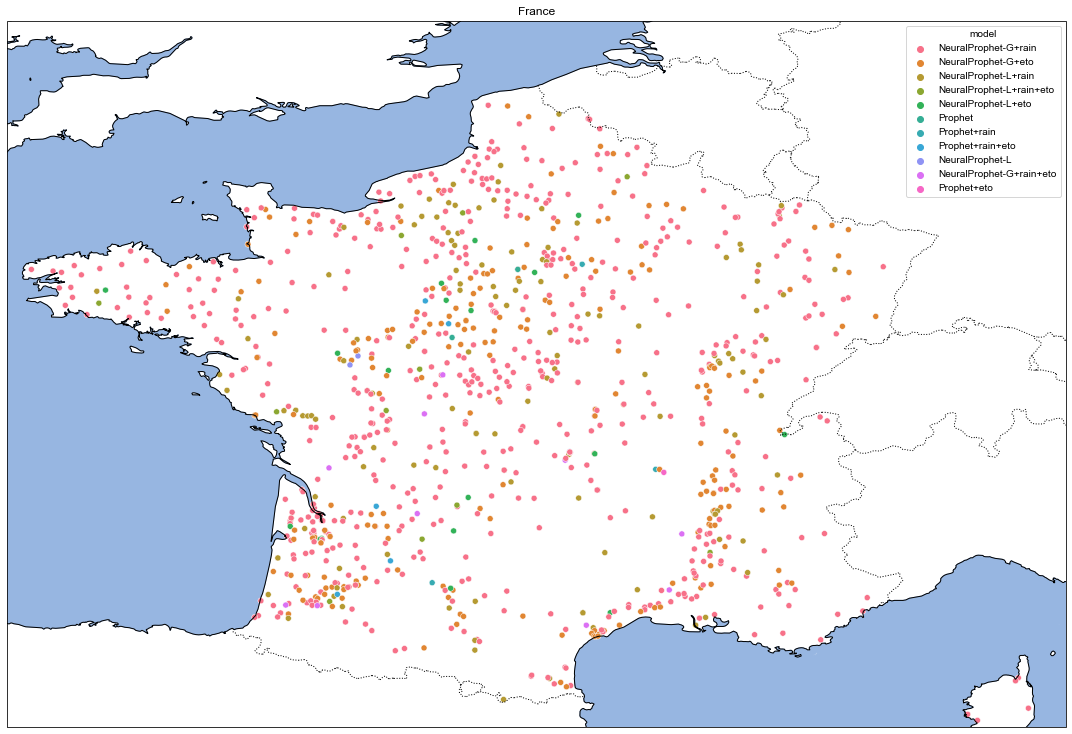

{0: 'NeuralProphet-G', 1: 'NeuralProphet-L', 2: 'Prophet', 3: 'Prophet+eto', 4: 'Prophet+rain', 5: 'Prophet+rain+eto', 6: 'NeuralProphet-L+rain+eto', 7: 'NeuralProphet-L+eto', 8: 'NeuralProphet-L+rain', 9: 'NeuralProphet-G+rain+eto', 10: 'NeuralProphet-G+eto', 11: 'NeuralProphet-G+rain'}
[4, 2]
[4, 3]
[9, 10]


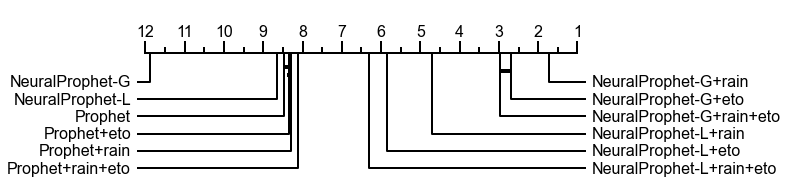

In [28]:
show_performance(deeplearning_result, show_map=True, barplot_fname='Images/boxplot-prophet.eps', cd_fname='Images/cd-prophet.eps')

In [29]:
best_prophet_models = {'NeuralProphet-G+rain', 'NeuralProphet-G+eto', 'NeuralProphet-L', 'NeuralProphet-G'}

# Merge every results

In [30]:
all_result = pd.concat([legacy_result, deepar_result, deeplearning_result])
all_result = all_result[all_result.use_exo_bdlisa==False]

filter_cols = ['id_piezo', 'model', 'type', 'use_exo_rain', 'use_exo_eto', 'use_exo_bdlisa', 'rmsse', 'rmse']
all_result_filtered = all_result[filter_cols]

#all_result_filtered = all_result_filtered.apply(lambda row: rename_model(row), axis=1)

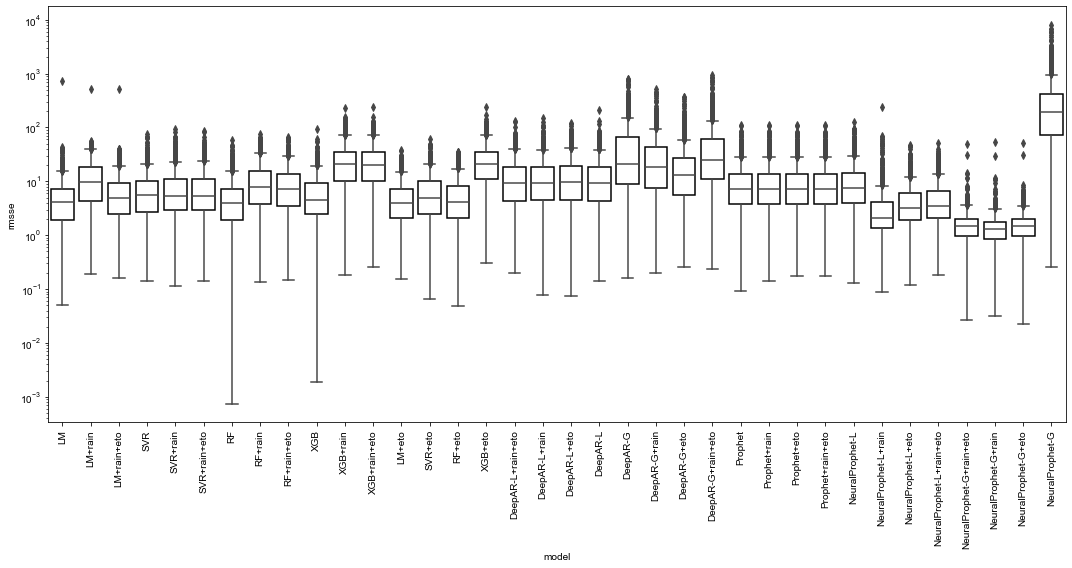

model        DeepAR-G  DeepAR-G+eto  DeepAR-G+rain  DeepAR-G+rain+eto  \
rmsse mean  57.680631     24.334162      35.574532          56.142484   
      std   96.156533     37.152423      52.643441          94.505637   

model        DeepAR-L  DeepAR-L+eto  DeepAR-L+rain  DeepAR-L+rain+eto  \
rmsse mean  14.723336     14.898500      14.705740          14.382224   
      std   16.689749     15.776049      16.313824          15.275161   

model              LM    LM+eto  ...    RF+rain  RF+rain+eto       SVR  \
rmsse mean   6.347190  5.582148  ...  11.301827    10.336519  8.142766   
      std   22.936639  5.159568  ...  10.823635     9.852539  8.846874   

model        SVR+eto  SVR+rain  SVR+rain+eto       XGB    XGB+eto   XGB+rain  \
rmsse mean  7.332672  8.801061      8.741238  7.289935  26.445743  26.426847   
      std   7.604155  9.899599      9.611169  7.936318  22.759168  23.163022   

model       XGB+rain+eto  
rmsse mean     25.716882  
      std      22.603823  

[2 rows x 36 columns]

In [31]:
plot_stats(all_result_filtered, figsize=(15, 8), fname='Images/boxplot-all.eps')

- On peut voir que l'utilisation des données exogènes dégrade les performances de LM, et ceci en particulier lorsqu'on utilise la pluie. C'est également le cas pour RF, XGB, 
- Les données exogènes dégradent légèrement le modèle SVR et n'ont aucun apport pour les modèles ARIMA, Prophet 
- DeepAR-Global est beaucoup moins bon que DeepAR-Local.
- On observe une amélioration considérable des prévisions de NeuralProphet lorsque les données exogènes sont utilisées, en particulier lorsque seule la pluie est utilisée. Une amélioration est également observée sur le modèle Conv, mais elle est très légère.

On vera par la suite à l'aide d'un diagramme de différence critique si ces améliorations/détériorations sont statistiquement significatives.

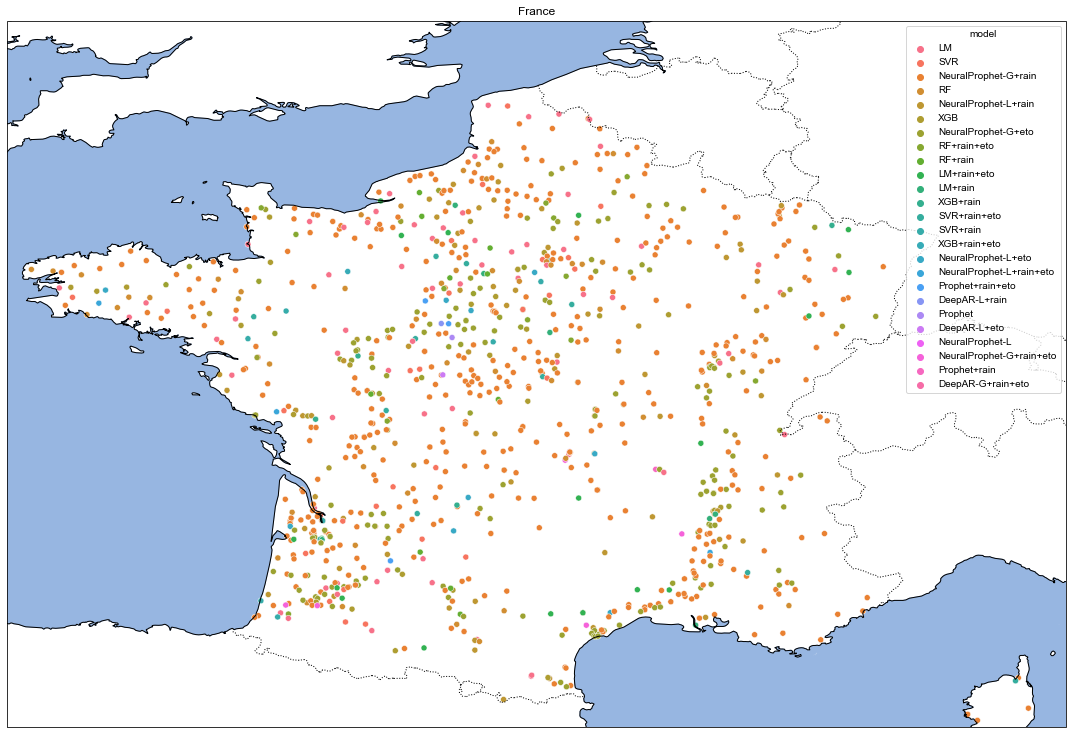

In [39]:
plot_best_models(all_result_filtered)

In [32]:
commons = set(common_piezo.values)
models_with_no_result = []
for m in all_result_filtered.model.unique():
    tmp = all_result_filtered[all_result_filtered.model == m].dropna()
    if tmp.shape[0] > 0:
        commons = commons.intersection(tmp.id_piezo)
    else:
        models_with_no_result.append(m)

print('Number of common piezo: ', len(commons), '\nModels without results:', models_with_no_result)

Number of common piezo:  1026 
Models without results: []


In [33]:
common_df = all_result_filtered[all_result_filtered.id_piezo.isin(commons)]
common_df = common_df[~common_df.model.isin(models_with_no_result)]
common_df = common_df.rename(columns={'id_piezo': 'dataset_name', 'model': 'classifier_name', 'rmsse': 'accuracy'})

In [34]:
# A dataframe with all performance
pd.pivot(data=common_df, columns='classifier_name', values='accuracy', index='dataset_name').to_csv('all-performance.csv')

{0: 'NeuralProphet-G', 1: 'DeepAR-G+rain+eto', 2: 'XGB+eto', 3: 'XGB+rain+eto', 4: 'XGB+rain', 5: 'DeepAR-G', 6: 'DeepAR-G+rain', 7: 'DeepAR-G+eto', 8: 'DeepAR-L+eto', 9: 'DeepAR-L', 10: 'LM+rain', 11: 'DeepAR-L+rain+eto', 12: 'DeepAR-L+rain', 13: 'RF+rain', 14: 'NeuralProphet-L', 15: 'Prophet', 16: 'Prophet+eto', 17: 'Prophet+rain', 18: 'Prophet+rain+eto', 19: 'RF+rain+eto', 20: 'SVR+rain', 21: 'SVR+rain+eto', 22: 'SVR', 23: 'XGB', 24: 'SVR+eto', 25: 'LM+rain+eto', 26: 'RF+eto', 27: 'RF', 28: 'LM', 29: 'NeuralProphet-L+rain+eto', 30: 'LM+eto', 31: 'NeuralProphet-L+eto', 32: 'NeuralProphet-L+rain', 33: 'NeuralProphet-G+rain+eto', 34: 'NeuralProphet-G+eto', 35: 'NeuralProphet-G+rain'}
[1, 5]
[2, 4, 6]
[3, 6]
[8, 9, 10, 11, 12]
[14, 16, 19, 17, 15]
[14, 16, 19, 18]
[14, 16, 13, 17, 15]
[14, 16, 13, 18]
[20, 21, 22]
[22, 24, 25]
[23, 24, 25]
[26, 27, 28]
[27, 28, 29, 30]
[33, 34]


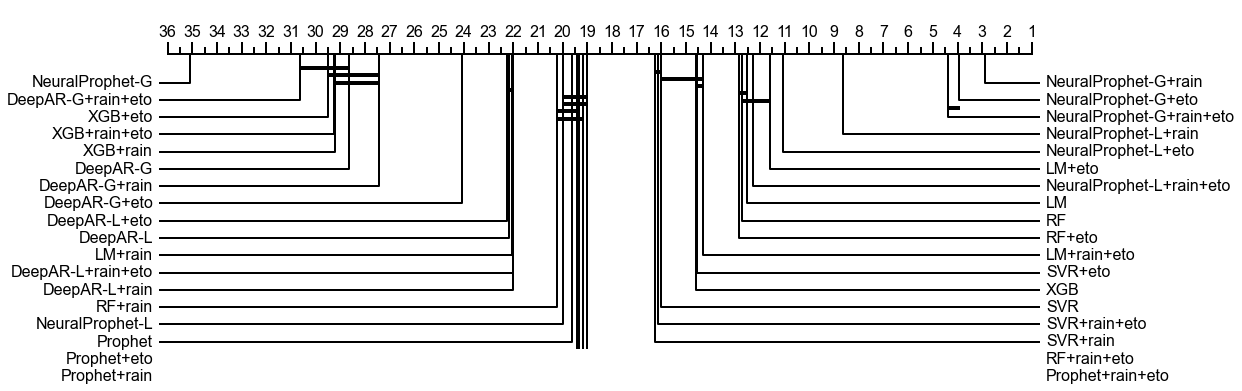

In [35]:
common_df.accuracy = -common_df.accuracy
draw_cd_diagram(common_df, fig_width=15, fname='Images/cd-all.eps')

- Le modèle linéaire (LM) est celui qui donnes les meilleures prévisions lorsqu'il y a pas de données exogènes.
- NeuralProphet est la combinaison qui donne les meilleures prévisions en présence de données exogènes, en particulier en présence de données pluviométriques.
- NeuralProphet est meilleur en mode Global
- L'utilisation des données exogènes améliore significativement les prévisions de NeuralProphet. Les meilleures prévisions sont obtenues en utilisant uniquement la pluie. 
- Les données exogènes n'ont pas d'influence sur le modèle Prophet et ARIMA
- DeepAR-Local donne des prévisions significativement plus justes que DeepAR-Global. D'ailleurs DeepAR-Global est le modèle le moins bon.
- La dégradation observée sur les prévisions de XGB et RF lorsque les données exogènes sont utilisées est non négligeable.
- La combinaison Conv+rain+eto donne des prévisions similaires à DeepAR-Local. Ce qui est remarquable étant donné la simplicité du modèle Conv et son temps d'apprentissage réduit.

{0: 'NeuralProphet-G', 1: 'DeepAR-G+rain+eto', 2: 'XGB+eto', 3: 'DeepAR-G+rain', 4: 'DeepAR-G+eto', 5: 'LM+rain', 6: 'DeepAR-L', 7: 'NeuralProphet-L', 8: 'LM+rain+eto', 9: 'LM+eto', 10: 'NeuralProphet-G+eto', 11: 'NeuralProphet-G+rain'}
[2, 3]
[5, 6]


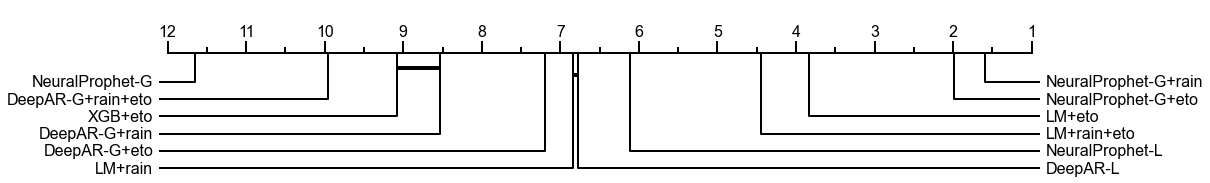

In [36]:
all_best = best_legacy_models.union(best_deepar_models).union(best_prophet_models)
draw_cd_diagram(common_df[common_df.classifier_name.isin(all_best)], fig_width=15, fname='Images/cd-all-best.eps')

# Plot some forecasts

In [49]:
neuralProphetRain = all_result[(all_result.model=='NeuralProphet-G+rain') & (all_result.use_exo_rain) & (~all_result.use_exo_eto) & (~all_result.use_exo_bdlisa)]
h_cols = neuralProphetRain.columns[neuralProphetRain.columns.str.startswith('h')]
neuralProphetRain = neuralProphetRain.set_index('id_piezo')[h_cols]
neuralProphetRain.head()

,h1,h2,h3,h4,h5,h6,h7,h8,h9,h10,...,h84,h85,h86,h87,h88,h89,h90,h91,h92,h93
id_piezo,,,,,,,,,,,,,,,,,,,,,
00065X0148/P,0.775936,0.845409,0.935739,1.003435,1.048758,1.069359,1.103693,0.883974,0.887938,0.918365,...,0.840830,0.899403,0.922857,0.928490,0.959660,1.030748,1.056622,0.837044,0.701065,0.285860
00068X0010/F295,24.816805,24.876612,24.874853,24.883207,24.916159,24.938890,24.909079,24.876314,24.939700,24.968775,...,23.808023,23.794329,23.738550,23.724398,23.694056,23.680613,23.636309,23.305834,23.478193,23.033201
00127X0873/PZ1,1.078173,1.110266,1.122379,1.092396,1.098412,1.090616,1.056395,1.018908,1.127817,1.149361,...,0.955477,0.958261,1.052299,1.017111,1.004213,1.004990,0.989723,0.971622,1.019255,0.882137
00134X0127/PZ1,22.434015,22.454760,22.465440,22.463133,22.463740,22.466470,22.424986,22.356543,22.422804,22.432177,...,22.200342,22.200232,22.190820,22.186522,22.189775,22.200056,22.178595,22.100400,22.131521,21.992704
00148D0177/F2,6.700272,6.713194,6.711308,6.716801,6.725126,6.746904,6.733427,6.686462,6.750181,6.760105,...,6.026003,6.037352,6.042555,6.045155,6.053492,6.071001,6.075321,5.885187,5.822000,5.365976


In [50]:
history = pd.read_csv('../data_collection/dataset_nomissing_linear.csv', sep=',', index_col='bss', parse_dates=['time'])
history = history[history.time < "2021-01-16"]

In [51]:
history.loc['00065X0148/P']

,Unnamed: 0,time,tp,e,p
bss,,,,,
00065X0148/P,2398,2015-01-01,0.000015,-0.005951,0.89
00065X0148/P,2399,2015-01-02,0.000791,-0.012997,0.95
00065X0148/P,2400,2015-01-03,0.012880,-0.009395,0.72
00065X0148/P,2401,2015-01-04,0.000005,-0.007145,0.70
00065X0148/P,2402,2015-01-05,0.000072,-0.002743,0.78
...,...,...,...,...,...
00065X0148/P,4600,2021-01-11,0.001994,-0.005845,1.08
00065X0148/P,4601,2021-01-12,0.007698,-0.020109,0.81
00065X0148/P,4602,2021-01-13,0.005463,-0.003029,0.67


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

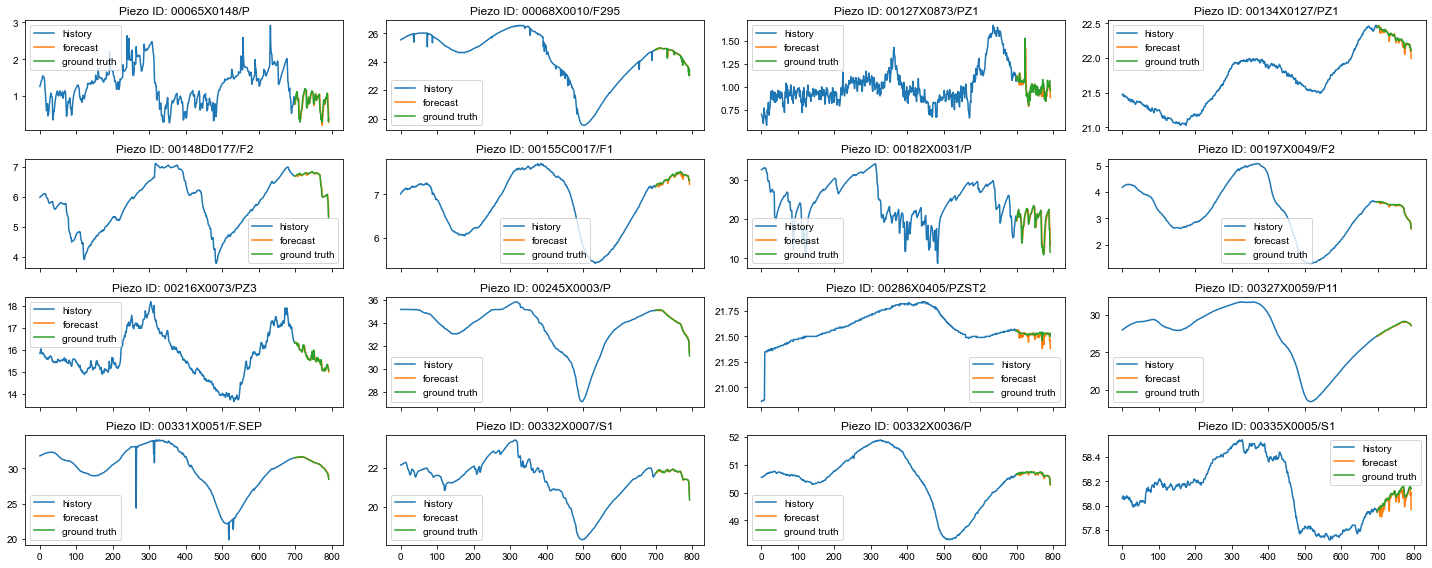

In [52]:
h_length = 700
horizon = 93
id_piezo = '00065X0148/P'

nrows = 4
ncols = 4
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=True, sharey=False, figsize=(20, 8), tight_layout=True)

for i, id_piezo in enumerate(neuralProphetRain.index[:(ncols*nrows)]):
    h_values = history.loc[id_piezo].p.values[-h_length-horizon:-horizon] # history
    f_values = np.insert(neuralProphetRain.loc[id_piezo].values, 0, h_values[-1]) # forecasts
    t_values = history.loc[id_piezo].p.values[-horizon-1:] # ground truths for forecasts
    
    h_index = np.arange(h_length)
    f_index = np.arange(h_length - 1, h_length + horizon)
    
    r = i // ncols
    c = i - r * ncols
    
    axes[r,c].plot(h_index, h_values, label='history')
    axes[r,c].plot(f_index, f_values, label='forecast')
    axes[r,c].plot(f_index, t_values, label='ground truth')
    axes[r,c].set_title(f'Piezo ID: {id_piezo}')
    axes[r,c].legend()
    
plt.tight_layout()
plt.savefig('Images/some-forecasts.eps')